In [1]:
!pip install "gluonts[mxnet,pro]"
!pip install "gluonts[torch,pro]"
!pip install yfinance


In [32]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (30, 10)})

import sys
import os

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.mx import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.evaluation import make_evaluation_predictions



sources :
 <https://ts.gluon.ai/stable/tutorials/forecasting/quick_start_tutorial.html>
 <https://aws.amazon.com/fr/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/>


## BTC-USD Hourly - Bitstamp

In [4]:
btc_usd_h = pd.read_csv("data/Bitstamp_BTCUSD_1h.csv")
btc_usd_h = btc_usd_h.iloc[::-1]
btc_usd_h = btc_usd_h[["date", "close"]]
btc_usd_h.set_index("date", inplace=True)
btc_usd_h.head()
btc_usd_h.shape

,close
date,
2018-05-15 06:00:00,8740.99
2018-05-15 07:00:00,8739.00
2018-05-15 08:00:00,8728.49
2018-05-15 09:00:00,8708.32
2018-05-15 10:00:00,8795.90


(38467, 1)

(13225, 1)

<AxesSubplot:xlabel='date'>

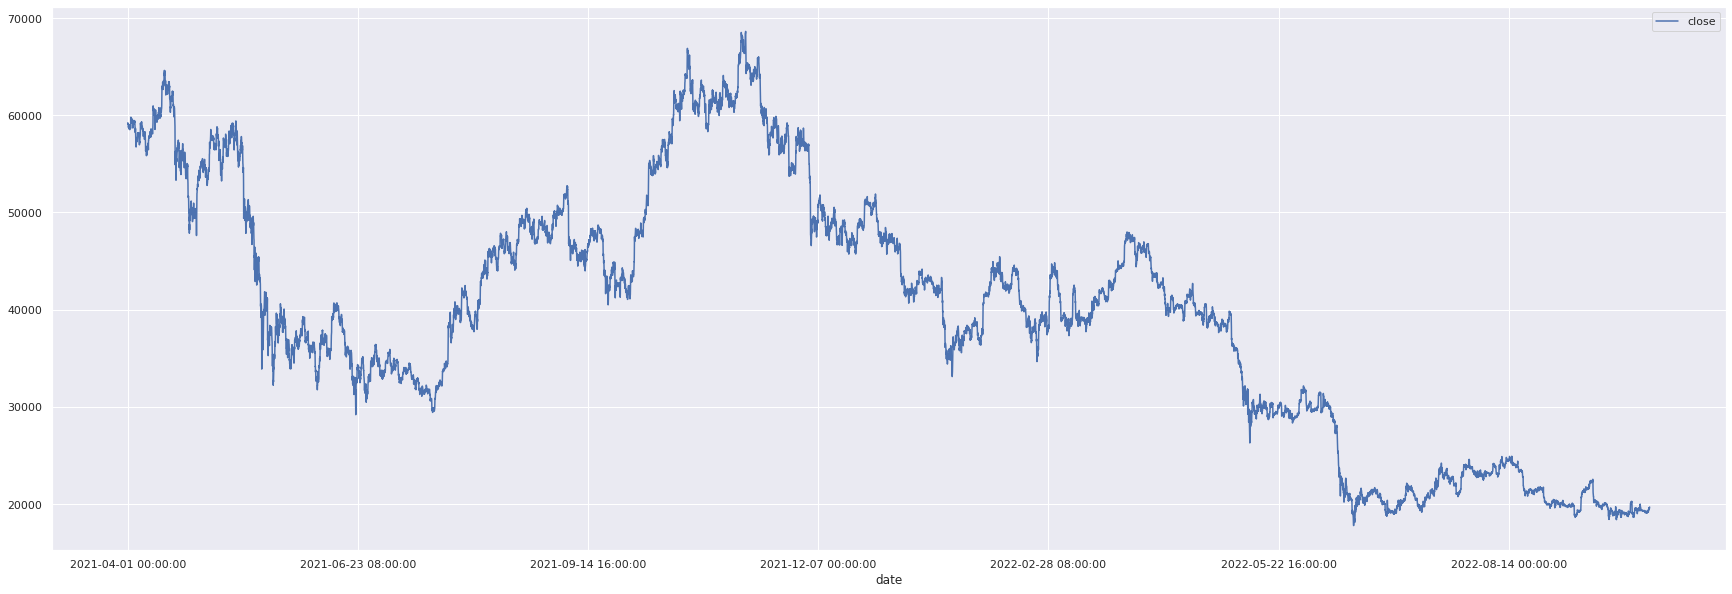

In [29]:
# let's keep only the latests values which represents the actual behavior
# + we should keep only the last 6 months for modeling
# + also, we should only try to predict at the maximum 3 months
btc_usd_h = btc_usd_h[btc_usd_h.index > "2021-04-01"]
btc_usd_h.shape
btc_usd_h.plot()

### Auto Arima

In [7]:
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima


In [8]:
f = Forecaster(y=btc_usd_h.close,current_dates=btc_usd_h.index)
f

Forecaster(
    DateStartActuals=2021-01-01T00:00:00.000000000
    DateEndActuals=2022-10-04T00:00:00.000000000
    Freq=H
    N_actuals=15385
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [15]:
# generate 48hours
f.generate_future_dates(10)
f.set_test_length(.2) # 20% test set
f.set_estimator('arima') # set arima

In [16]:
f.manual_forecast(order=(6,1,2),call_me='arima2')


<AxesSubplot:xlabel='Date', ylabel='Values'>

Text(0.5, 1.0, 'ARIMA Test-Set Performance')

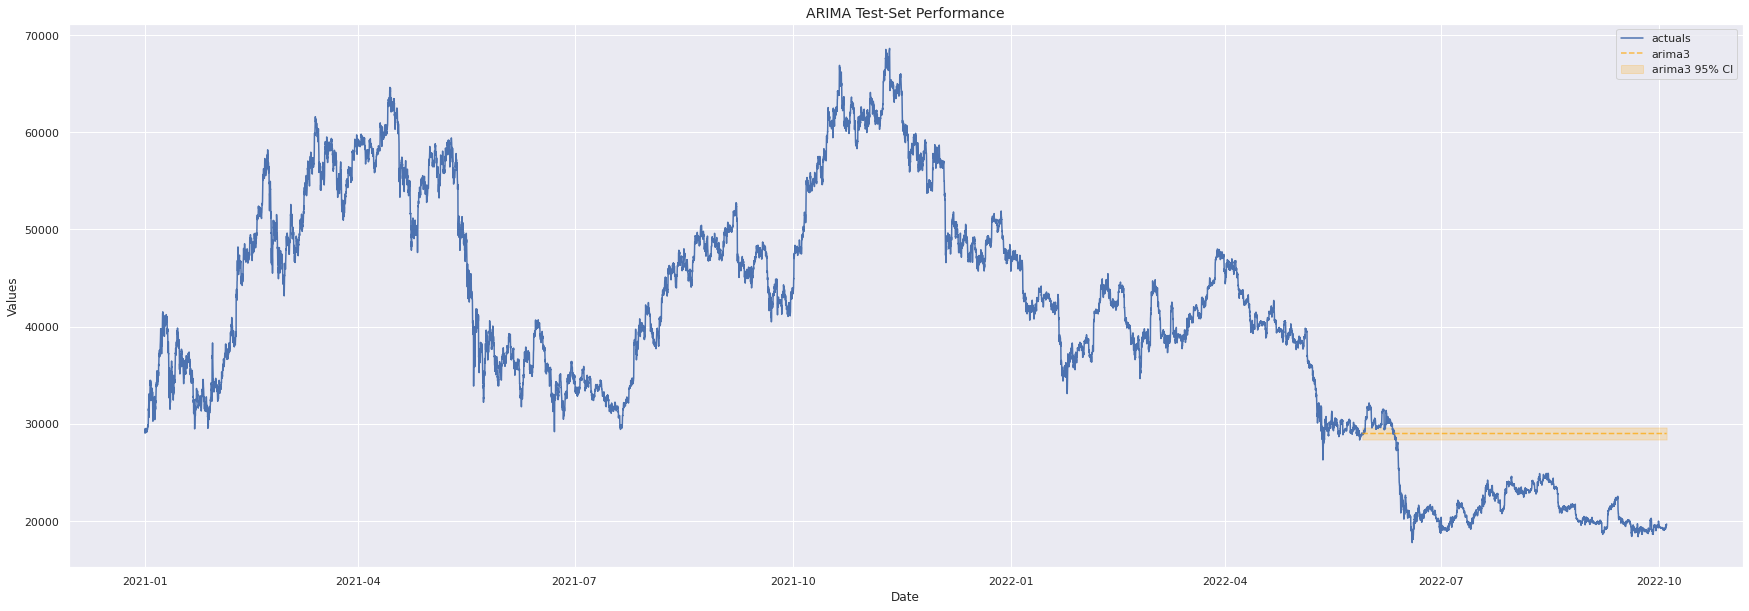

In [17]:
f.plot_test_set(ci=True) # view test results
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

In [19]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2, 
    max_D=2,
    max_Q=2,
    max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=181040.359, Time=11.86 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=181049.872, Time=0.23 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=181052.137, Time=1.80 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=181052.007, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=181047.872, Time=0.11 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=181047.793, Time=9.62 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=181047.911, Time=9.33 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=181032.825, Time=25.31 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=181030.835, Time=18.72 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=181036.817, Time=5.21 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=181032.478, Time=5.82 sec


KeyboardInterrupt: 

In [ ]:
f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

NameError: name 'f' is not defined

In [ ]:
f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [ ]:
f.regr.summary()

### GluonTS - Transformer model

This part of the notebook is heavily based on the Quick Start Tutorial and the Extended Forecasting Tutorial that are both provided with the package.

In [31]:
from gluonts.dataset.common import ListDataset

freq = "1h"
start = pd.Period("2021-02-01 00:00:00", freq=freq)
# predict 10 days (240 hours)
prediction_length = 240
# context of 1 month (720 hours)
context_length = 720


train_ds = ListDataset(
    [{"start": btc_usd_h.index[0], "target": btc_usd_h.close[:-prediction_length]}],
    freq=freq
)

test_ds = ListDataset(
    [{"start": btc_usd_h.index[0], "target": btc_usd_h.close[:]}],
    freq=freq
)

#### DeepAR Estimator

In [37]:
estimator = DeepAREstimator(
	prediction_length=prediction_length, 
	context_length=context_length,
	freq=freq, 
	distr_output=StudentTOutput(),
	trainer=Trainer(
		epochs=10,
		learning_rate=1e-3,
		num_batches_per_epoch=100,
		patience=2
	)
)

predictor = estimator.train(training_data=train_ds)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s, epoch=10/10, avg_epoch_loss=7.71]


In [38]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

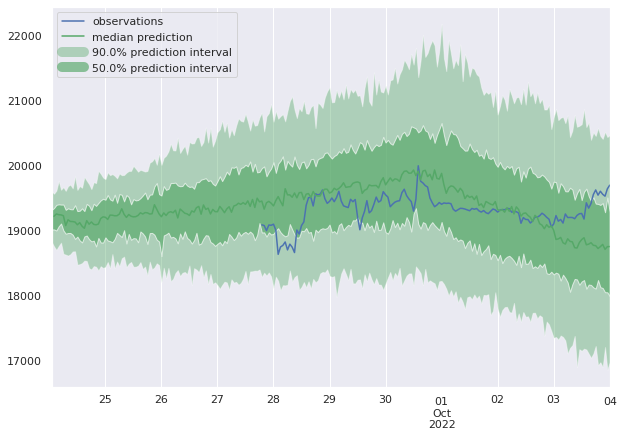

In [39]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
	
plot_prob_forecasts(tss[0], forecasts[0])


#### Transformer Estimator

In [40]:
estimator = TransformerEstimator(prediction_length=prediction_length, freq=freq, trainer=Trainer(epochs=5))
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:27<00:00,  1.84it/s, epoch=5/5, avg_epoch_loss=9.27]


<AxesSubplot:>

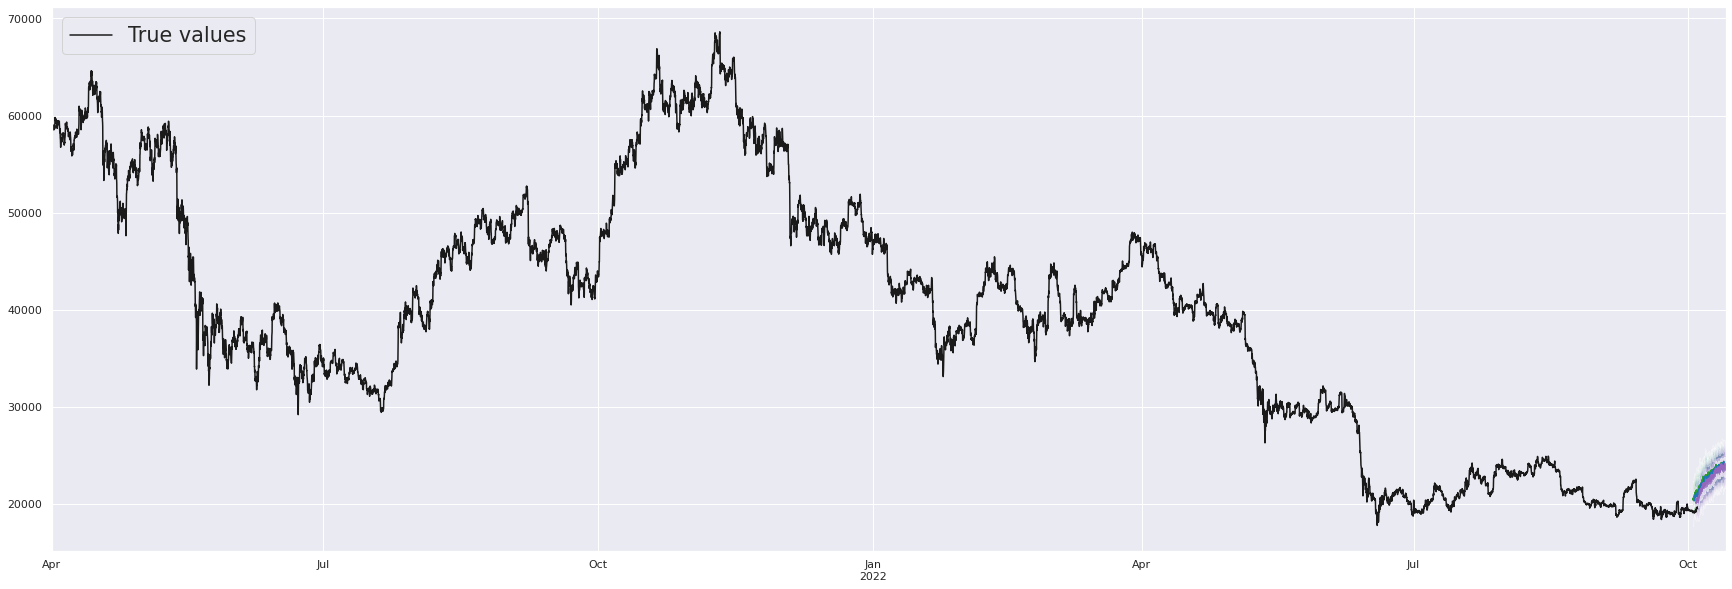

In [41]:

# Make predictions
true_values = to_pandas(list(test_ds)[0])
true_values.to_timestamp().plot(color="k")

prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = predictor.predict(prediction_input)

for color, prediction in zip(["green", "blue", "purple"], predictions):
    prediction.plot(color=f"tab:{color}")

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [42]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [43]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(
    -1,
)
dataset_test_entry = next(iter(test_ds))
dataset_test_entry["target"][:5]

array([59228.05, 59165.78, 59093.11, 59114.01, 58921.77], dtype=float32)

array([59228.05, 59165.78, 59093.11, 59114.01, 58921.77], dtype=float32)

In [44]:
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Number of sample paths: 100
Dimension of samples: (100, 240)
Start date of the forecast window: 2022-09-24 01:00
Frequency of the time series: <Hour>
Mean of the future window:
 [20350.34  20579.797 20677.191 20908.205 20777.717 20847.152 21050.135
 21002.25  21148.902 21134.31  21209.145 21012.074 21052.6   21130.898
 21047.422 21180.377 21270.125 21166.49  21248.373 21283.268 21146.027
 21258.09  21077.332 21256.652 21353.248 21343.67  21527.197 21606.682
 21378.66  21516.8   21501.645 21520.062 21661.43  21722.85  21660.877
 21770.98  21458.828 21750.283 21726.615 21718.074 21694.55  21764.207
 21926.615 21783.953 22062.87  21864.99  22047.63  21906.61  21899.242
 22114.525 22426.234 22188.287 22294.648 22396.488 22215.373 22059.928
 22231.068 22398.145 22484.87  22220.73  22256.23  22227.93  22081.453
 22519.592 22363.303 22321.498 22392.32  22380.197 22069.19  22012.693
 22331.393 22114.21  22358.18  22428.115 22513.053 22483.01  22561.74
 22632.598 22609.873 22914.695 22802.195 2

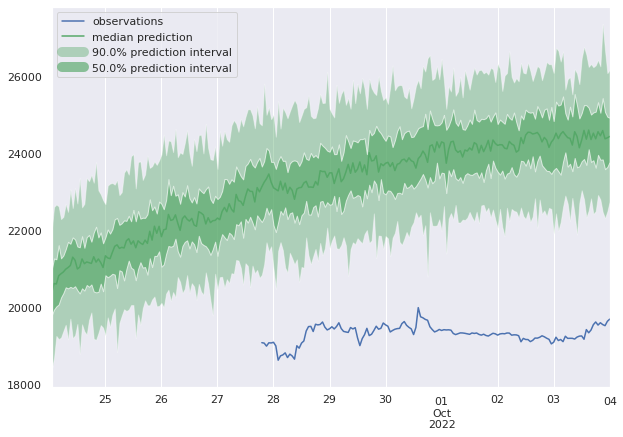

In [45]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
	
plot_prob_forecasts(ts_entry, forecast_entry)
